In [1]:
%load_ext autoreload
%autoreload 2
# import packages
from cl_sster import cl_sster
import numpy as np
import os
import scipy.io as sio
from postprocessing_utils import calc_isc, calc_isc_train
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from postprocessing_utils import plot_dendrogram
import torch
import mne
fs = 125
# Load video data
datadir = r'D:\Data\Emotion\FACED\Processed_data_filter_epoch_0.50_40_manualRemove_ica'
datadir = '/mnt/repo3/zqz/Emotion_EEG_Dataset/SEED_SJTU/SEED-V/AutoICA_Processed/SEED_V/Processed_data_filter_0.50_47.00_AutoICA_Cus_Threshold/data'
print(datadir)
video_len = [81,63,73,78,69,90,56,60,105,45,60,81,35,44,38,43,55,69,73,129,77,75,34,37,67,63,54,77]
video_len = [72,96,237,187,147,258,297,69,264,141,174,172,234,240,155,\
             237,189,66,127,131,59,240,230,120,99,187,116,95,219,76,\
             291,65,165,90,52,239,84,72,228,285,220,118,207,131,178]
for i in range(len(video_len)):
    video_len[i] += 0.008
n_points = np.array(video_len) * fs
# n_points = n_points.astype(int)

n_vids = len(video_len)
data_paths = os.listdir(datadir)
data_paths.sort()
# n_subs = 123
# chn = 30
n_subs = 16
chn = 60
count = 0
data = np.zeros((n_subs, np.sum(n_points).astype(int), chn))
for idx, path in enumerate(data_paths):
    if 'all' in path:
        data[count,:,:] = sio.loadmat(os.path.join(datadir, path))['merged_data_all_cleaned'].transpose()
        count += 1
print(data.shape)

# Normalization without outliers
print('Normalizing')
for sub in range(n_subs):
    thr = 30 * np.median(abs(data[sub]))
    data[sub] = (data[sub] - np.mean(data[sub][data[sub] < thr])) / np.std(data[sub][data[sub] < thr])

/mnt/repo3/zqz/Emotion_EEG_Dataset/SEED_SJTU/SEED-V/AutoICA_Processed/SEED_V/Processed_data_filter_0.50_47.00_AutoICA_Cus_Threshold/data
(16, 919920, 60)
Normalizing


### 初始化cl_sster类

In [2]:
# Train the cross-validation model
epochs_pretrain = 100
%load_ext autoreload
%autoreload 2
timeLen = 30
isFirstTrain=False
SEED_V_labels = np.array([4, 1, 3, 2, 0] * 3 + [2, 1, 3, 0, 4] * 6)
from cl_sster import cl_sster
cl_model_0wd = cl_sster(n_folds=16, weight_decay=0.00015, epochs_pretrain=epochs_pretrain, timeLen=timeLen, fs=fs, data_type='video', model='attention', labels=SEED_V_labels)
cl_model_0wd.load_data(data, n_points) # fs: sampling rate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
is cuda available: True
The results will be saved to: results/video/nfold16_timeLen30_wd0.000150_epochs100_tfLen30_avgPool15_timeStep15.000_cv


### 指定fold，从此开始全流程

In [1]:
%load_ext autoreload
%autoreload 2
fold = 0
cl_model_0wd.ref_feature(fold, 30)

NameError: name 'cl_model_0wd' is not defined

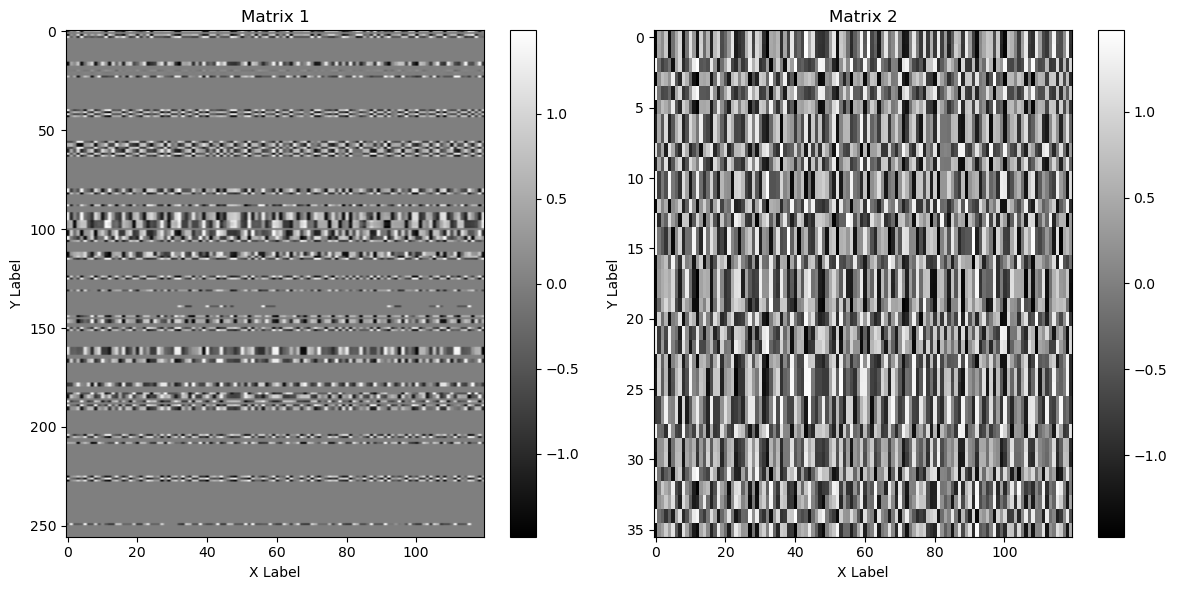

In [13]:
sub = 0
sample = 50

feature_raw_img = cl_model_0wd.feature_raw[fold][0, 5]
feature_raw_img = feature_raw_img.transpose((1, 0, 2)).reshape(256, -1)
feature_nonzero_img = feature_raw_img[cl_model_0wd.non_zero_indices[fold]]

import matplotlib.pyplot as plt
# 使用 matplotlib 的 imshow 函数将矩阵以灰度图形式显示出来
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1行2列

# 绘制第一个图
axes[0].imshow(feature_raw_img, cmap='gray', aspect='auto')
axes[0].set_title('Matrix 1')
axes[0].set_xlabel('X Label')
axes[0].set_ylabel('Y Label')
axes[0].grid(False)
axes[0].colorbar = plt.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二个图
axes[1].imshow(feature_nonzero_img, cmap='gray', aspect='auto')
axes[1].set_title('Matrix 2')
axes[1].set_xlabel('X Label')
axes[1].set_ylabel('Y Label')
axes[1].grid(False)
axes[1].colorbar = plt.colorbar(axes[1].images[0], ax=axes[1])

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

### 计算DE

In [14]:
%load_ext autoreload
%autoreload 2
cl_model_0wd.compute_de(fold)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Computing DE
(16, 508, 36, 30)
Running Norm
Smooth LDS


In [15]:
print(cl_model_0wd.de[fold].shape)
print(cl_model_0wd.de_norm[fold].shape)
print(cl_model_0wd.de_smooth[fold].shape)
print(cl_model_0wd.feature_nonzero[fold].shape)

(16, 508, 36, 30)
(16, 508, 36, 30)
(16, 508, 36, 30)
(16, 508, 30, 36, 4)


In [16]:
fold

0

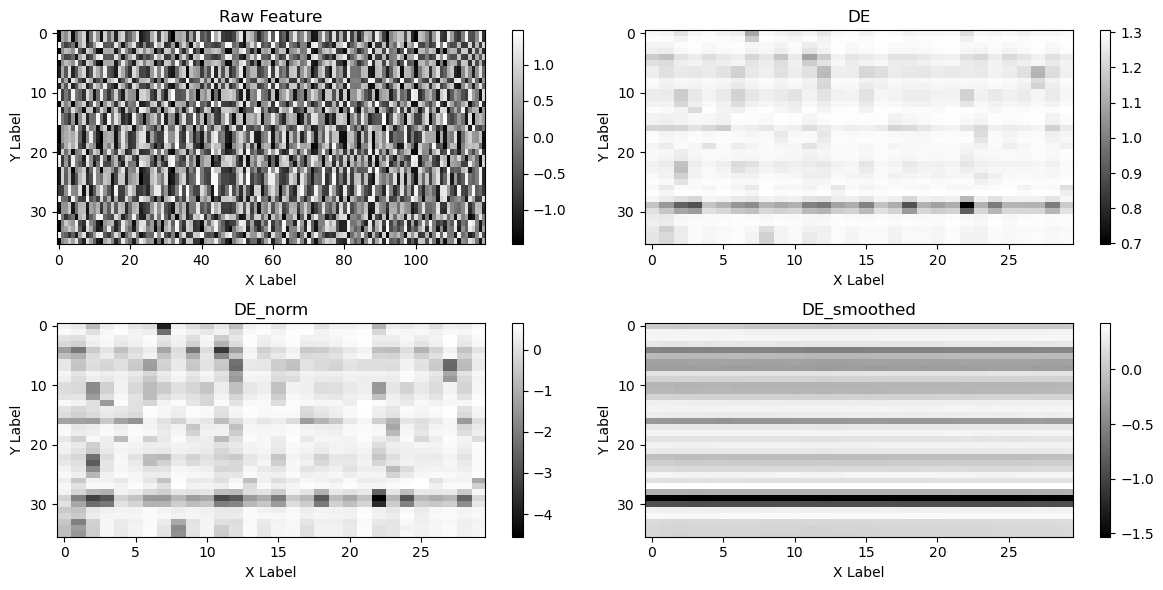

In [17]:
sub = 0
sample = 50
feature_raw_img = cl_model_0wd.feature_raw[fold][0, 5]
feature_raw_img = feature_raw_img.transpose((1, 0, 2)).reshape(256, -1)
feature_nonzero_img = feature_raw_img[cl_model_0wd.non_zero_indices[fold]]
de_img = cl_model_0wd.de[fold][sub][sample]
de_normed = cl_model_0wd.de_norm[fold][sub][sample]
de_smooth = cl_model_0wd.de_smooth[fold][sub][sample]
# de_cus = cl_model_0wd.de_cus[fold][0]

import matplotlib.pyplot as plt
# 使用 matplotlib 的 imshow 函数将矩阵以灰度图形式显示出来
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # 1行2列

# 绘制第1个图
axes[0, 0].imshow(feature_nonzero_img, cmap='gray', aspect='auto', interpolation='nearest')
axes[0, 0].set_title('Raw Feature')
axes[0, 0].set_xlabel('X Label')
axes[0, 0].set_ylabel('Y Label')
axes[0, 0].grid(False)
axes[0, 0].colorbar = plt.colorbar(axes[0, 0].images[0], ax=axes[0,0])

# 绘制第2个图
axes[0,1].imshow(de_img, cmap='gray', aspect='auto', interpolation='nearest')
axes[0,1].set_title('DE')
axes[0,1].set_xlabel('X Label')
axes[0,1].set_ylabel('Y Label')
axes[0,1].grid(False)
axes[0,1].colorbar = plt.colorbar(axes[0,1].images[0], ax=axes[0,1])

# 绘制第3个图
axes[1,0].imshow(de_normed, cmap='gray', aspect='auto', interpolation='nearest')
axes[1,0].set_title('DE_norm')
axes[1,0].set_xlabel('X Label')
axes[1,0].set_ylabel('Y Label')
axes[1,0].grid(False)
axes[1,0].colorbar = plt.colorbar(axes[1,0].images[0], ax=axes[1,0])

# 绘制第4个图
axes[1,1].imshow(de_smooth, cmap='gray', aspect='auto', interpolation='nearest')
axes[1,1].set_title('DE_smoothed')
axes[1,1].set_xlabel('X Label')
axes[1,1].set_ylabel('Y Label')
axes[1,1].grid(False)
axes[1,1].colorbar = plt.colorbar(axes[1,1].images[0], ax=axes[1,1])


# 绘制第5个图
# axes[2,0].imshow(de_cus.transpose(), cmap='gray', aspect='auto')
# axes[2,0].set_title('DE_Cus')
# axes[2,0].set_xlabel('X Label')
# axes[2,0].set_ylabel('Y Label')
# axes[2,0].grid(False)
# axes[2,0].colorbar = plt.colorbar(axes[2,0].images[0], ax=axes[2,0])


# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [18]:
def plot_gray_image(matrix):
    if len(matrix.shape) == 1:
        matrix = np.expand_dims(matrix, axis=0)
    plt.imshow(matrix, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.pause(40)
    

In [19]:
cl_model_0wd.de_smooth[fold].shape

(16, 508, 36, 30)

### MLP分类器训练

val [0]
train [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Training Progress:   0%|          | 0/1200 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 1200/1200 [06:46<00:00,  2.95it/s]


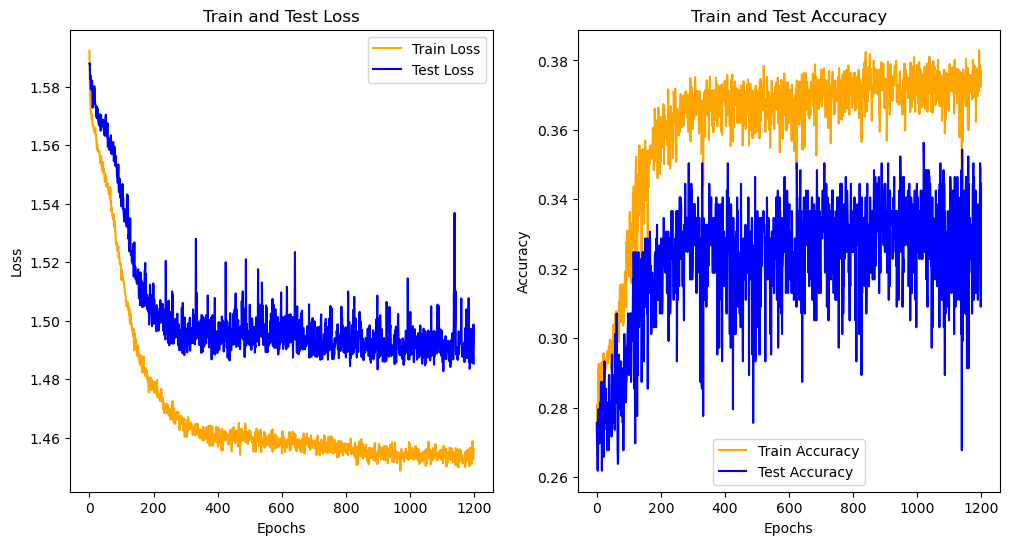

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


class DynamicMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(DynamicMLP, self).__init__()
        self.input_size = input_size[-1] * input_size[-2]
        hidden_size = 256
        self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.cuda()  # 将数据移动到 CUDA 设备上
            labels = labels.cuda()      # 将数据移动到 CUDA 设备上
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
            total += labels.size(0)
            loss += criterion(outputs, labels).item()
    accuracy = correct / total
    loss /= len(data_loader)
    return accuracy, loss

torch.cuda.set_device(7)

# 示例数据
batch_size = 64
epochs = 1200
train_loader, test_loader = cl_model_0wd.get_feature_dataloader(fold=fold, batch_size=batch_size)
input_size = train_loader.dataset.features.shape  # 获取输入特征向量的大小
output_size = len(np.unique(train_loader.dataset.labels))  # 获取输出类别的数量

# 创建模型实例和优化器
model = DynamicMLP(input_size, output_size)
model = model.cuda()  # 将模型移动到 CUDA 设备上
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.01)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 记录训练和测试的损失值和准确率
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 训练模型
from tqdm import tqdm  # 导入 tqdm

for epoch in tqdm(range(epochs), desc='Training Progress'):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features = features.cuda()  # 将数据移动到 CUDA 设备上
        labels = labels.cuda()      # 将数据移动到 CUDA 设备上
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 训练集准确率
    train_accuracy, _ = evaluate_accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)

    # 测试集准确率和损失值
    test_accuracy, test_loss = evaluate_accuracy(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # tqdm.write(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 绘制图表
plt.figure(figsize=(12, 6))

# 绘制损失值图表
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='orange')
plt.plot(test_losses, label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# 绘制准确率图表
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='orange')
plt.plot(test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


class DynamicMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(DynamicMLP, self).__init__()
        self.input_size = input_size[-1] * input_size[-2]
        hidden_size = 256
        self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.cuda()  # 将数据移动到 CUDA 设备上
            labels = labels.cuda()      # 将数据移动到 CUDA 设备上
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
            total += labels.size(0)
            loss += criterion(outputs, labels).item()
    accuracy = correct / total
    loss /= len(data_loader)
    return accuracy, loss

torch.cuda.set_device(7)

# 示例数据
batch_size = 64
epochs = 600
train_loader, test_loader = cl_model_0wd.get_feature_dataloader(fold=fold, batch_size=batch_size)
input_size = train_loader.dataset.features.shape  # 获取输入特征向量的大小
output_size = len(np.unique(train_loader.dataset.labels))  # 获取输出类别的数量

# 创建模型实例和优化器
model = DynamicMLP(input_size, output_size)
model = model.cuda()  # 将模型移动到 CUDA 设备上
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 记录训练和测试的损失值和准确率
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 训练模型
from tqdm import tqdm  # 导入 tqdm

for epoch in tqdm(range(epochs), desc='Training Progress'):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features = features.cuda()  # 将数据移动到 CUDA 设备上
        labels = labels.cuda()      # 将数据移动到 CUDA 设备上
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(optimizer.param_groups[0]['lr'])
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 训练集准确率
    train_accuracy, _ = evaluate_accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)

    # 测试集准确率和损失值
    test_accuracy, test_loss = evaluate_accuracy(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # tqdm.write(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# 绘制图表
plt.figure(figsize=(12, 6))

# 绘制损失值图表
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='orange')
plt.plot(test_losses, label='Test Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# 绘制准确率图表
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='orange')
plt.plot(test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.show()


KeyboardInterrupt: 